In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
from matplotlib import rc
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [2]:
rc('text', usetex=True)
rc('font', family='sans-serif')

In [2]:
numBlocks = 9
path = 'pavlovia_data/'

In [73]:
def load(filepath):
    df = pd.read_csv(filepath)
    df.drop(columns=['space_bar.keys', 'space_bar.rt', 'participant', 'session', 'date', 'expName',
                    'psychopyVersion', 'OS', 'frameRate', 'steps.thisRepN', 'steps.thisTrialN',
                    'steps.thisIndex', 'steps.ran', 'blocks.thisRepN', 'blocks.thisTrialN', 'blocks.thisN',
                    'blocks.thisIndex', 'blocks.ran'], inplace=True)
    df.dropna(how='all', inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns = 'index', inplace=True)
    df["commit"] = [1 if resp == 'up' or resp == 'down' else 0 for resp in df['resp.keys']]
    df["resp.keys"] = [1 if resp == 'up' else -1 if resp == 'down' else 0 for resp in df['resp.keys']]
    df["dPrice_dt"] = np.diff(df['price'], append=0)
    return df

In [74]:
def convert_to_bursty(choice, idx):
    '''Converts simulated choice data structure into a data structure of time lags (amount of time since last
    consuming a particular choice).
    
    Parameters
    ----------
    choice : numpy array
        The data structure containing the choice made for each time point t in the simulation.
        
    Returns
    -------
    lags : pandas DataFrame
        The DataFrame containing the time lags for choice 2 (choice_index = 1 denotes choice 2, = 0 
        denotes choice 1)
    dfTL.shape[0] : int
        The number of lags in the DataFrame
    
    '''
    choice_index = 1 - idx
    new_choice = [float(i) for i in choice]
    new_choice = [float('nan') if x==choice_index else x for x in new_choice]
    choicetime = []
    for i in range(0,len(new_choice)):
        if round(new_choice[i],1) == idx: # choice == 0 if event happen (e.g., go to gym)
            choicetime.append(i)
    time_lags = [choicetime[i] - choicetime[i-1] for i in range(1,len(choicetime))]
    dfTL = pd.DataFrame(time_lags, columns=['TL'])
    dfTL['counts'] = choicetime[0:len(choicetime)-1]
    lags = dfTL.groupby(dfTL['TL']).count()
    return np.array(time_lags), np.array(lags.index), np.array(lags.counts), dfTL.shape[0]

In [97]:
def compute_burstiness(lags_line):
    mean = np.mean(lags_line)
    std = np.std(lags_line)
    return (std - mean)/(std+mean)

def compute_mean(lags_line):
    return np.mean(lags_line)

def compute_std(lags_line):
    return np.std(lags_line)

def plot_bursty(data):
    q = []; eps = []; b_i = [];
    fig, ax = plt.subplots(figsize=(5,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.1)
    for i in range(1,numBlocks+1):
        curBlock = block(i,data)
        all_lags, lags, freq, N = convert_to_bursty(np.array(curBlock.commit), 1)
        q.append(curBlock['q_prob'].iloc[1]); eps.append(curBlock['eps_prob'].iloc[1])
        b_i.append(compute_burstiness(all_lags))
        
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    plt.subplot(121)
    plt.scatter(q,b_i)
    plt.xlabel('$q$'); plt.ylabel('$B$')
    q_mdl = LinearRegression(); q_mdl.fit(q,b_i)
    plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(122)
    plt.scatter(eps,b_i)
    plt.xlabel('$\epsilon$'); plt.yticks([])
    eps_mdl = LinearRegression(); eps_mdl.fit(eps,b_i)
    plt.plot(eps, eps_mdl.predict(eps), 'r')
    plt.show()
    
def plot_mean(data):
    q = []; eps = []; mu_i = [];
    fig, ax = plt.subplots(figsize=(5,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.1)
    for i in range(1,numBlocks+1):
        curBlock = block(i,data)
        all_lags, lags, freq, N = convert_to_bursty(np.array(curBlock.commit), 1)
        q.append(curBlock['q_prob'].iloc[1]); eps.append(curBlock['eps_prob'].iloc[1])
        mu_i.append(compute_mean(all_lags))
        
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    plt.subplot(121)
    plt.scatter(q,mu_i)
    plt.xlabel('$q$'); plt.ylabel('$\mu$')
    q_mdl = LinearRegression(); q_mdl.fit(q,mu_i)
    plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(122)
    plt.scatter(eps,mu_i)
    plt.xlabel('$\epsilon$'); plt.ylabel('$B$')
    eps_mdl = LinearRegression(); eps_mdl.fit(eps,mu_i)
    plt.plot(eps, eps_mdl.predict(eps), 'r')
    plt.show()
    
def get_threshold(data):
    q = []; eps = []; up_price = []; down_price = []; change_up = []; change_down = []
    fig, ax = plt.subplots(figsize=(6,3.5),dpi=150)
    plt.subplots_adjust(wspace=0.5)
    for i in range(1,numBlocks+1):
        curBlock = block(i,data)
        ups = curBlock.index[curBlock['resp.keys'] == 1]
        ups = ups - 1
        ups = ups[1:]
        downs = curBlock.index[curBlock['resp.keys'] == -1]
        downs = downs - 1
        downs = downs[1:]
        q.append(curBlock['q_prob'].iloc[1]); eps.append(curBlock['eps_prob'].iloc[1])
        up_price.append(np.mean(data.iloc[ups]['price'])); down_price.append(np.mean(data.iloc[downs]['price']))
        change_up.append(np.mean(data.iloc[ups]['dPrice_dt']))
        change_down.append(np.mean(data.iloc[downs]['dPrice_dt']))
      
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    up_price = np.array(up_price); up_price = up_price.reshape(-1,1)
    down_price = np.array(down_price); down_price = down_price.reshape(-1,1)
    change_up = np.array(change_up); change_up = change_up.reshape(-1,1)
    change_down = np.array(change_down); change_down = change_down.reshape(-1,1)
    
    plt.subplot(221)
    plt.scatter(eps, up_price)
    plt.xlabel('$\epsilon$')
    plt.ylabel('$P$ when $s = s_+$')
    
    plt.subplot(222)
    plt.scatter(eps,down_price)
    plt.xlabel('$\epsilon$')
    plt.ylabel('$P$ when $s = s_-$')
    
    plt.subplot(223)
    plt.scatter(eps, change_up)
    plt.xlabel('$\epsilon$')
    plt.ylabel('$\\frac{dP}{dt}$ when $s=s_+$')
    
    plt.subplot(224)
    plt.scatter(eps, change_down)
    plt.xlabel('$\epsilon$')
    plt.ylabel('$\\frac{dP}{dt}$ when $s=s_-$')
    plt.show()
    
    
#     plt.subplot(221)
#     plt.scatter(q,up_price)
    
#     plt.subplot(222)
#     plt.scatter(q, down_price)
    

    
def plot_eps(data):
    eps = []; b_i = []; mu_i = []; std_i = [];
    fig, ax = plt.subplots(figsize=(7,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.4)
    for i in range(1,numBlocks+1):
        curBlock = block(i,data)
        all_lags, lags, freq, N = convert_to_bursty(np.array(curBlock.commit), 1)
        eps.append(curBlock['eps_prob'].iloc[1])
        b_i.append(compute_burstiness(all_lags))
        mu_i.append(compute_mean(all_lags))
        std_i.append(compute_std(all_lags))
    
    eps = np.array(eps); eps = eps.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    
    plt.subplot(131)
    plt.scatter(eps,b_i)
    plt.xlabel('$\epsilon$'); plt.ylabel('$B$')
    eps_mdl = LinearRegression(); eps_mdl.fit(eps,b_i)
    plt.plot(eps, eps_mdl.predict(eps), 'r')
    
    plt.subplot(132)
    plt.scatter(eps,mu_i)
    plt.xlabel('$\epsilon$'); plt.ylabel('$\mu$')
    eps_mdl = LinearRegression(); eps_mdl.fit(eps,mu_i)
    plt.plot(eps, eps_mdl.predict(eps), 'r')
    
    plt.subplot(133)
    plt.scatter(eps,std_i)
    plt.xlabel('$\epsilon$'); plt.ylabel('$\sigma$')
    eps_mdl = LinearRegression(); eps_mdl.fit(eps,std_i)
    plt.plot(eps, eps_mdl.predict(eps), 'r')
    plt.show()
    
    
    
def plot_q(data):
    q = []; b_i = []; mu_i = []; std_i = [];
    fig, ax = plt.subplots(figsize=(7,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.4)
    for i in range(1,numBlocks+1):
        curBlock = block(i,data)
        all_lags, lags, freq, N = convert_to_bursty(np.array(curBlock.commit), 1)
        q.append(curBlock['q_prob'].iloc[1])
        b_i.append(compute_burstiness(all_lags))
        mu_i.append(compute_mean(all_lags))
        std_i.append(compute_std(all_lags))
    
    q = np.array(q); q = q.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    
    plt.subplot(131)
    plt.scatter(q,b_i)
    plt.xlabel('$q$'); plt.ylabel('$B$')
    q_mdl = LinearRegression(); q_mdl.fit(q,b_i)
    plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(132)
    plt.scatter(q,mu_i)
    plt.xlabel('$q$'); plt.ylabel('$\mu$')
    q_mdl = LinearRegression(); q_mdl.fit(q,mu_i)
    plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(133)
    plt.scatter(q,std_i)
    plt.xlabel('$q$'); plt.ylabel('$\sigma$')
    q_mdl = LinearRegression(); q_mdl.fit(q,std_i)
    plt.plot(q, q_mdl.predict(q), 'r')
    plt.show()

In [98]:
def block(n, df):
    k = int(df.shape[0]/9)
    return df.iloc[(n-1)*k: n*k]

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:135: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


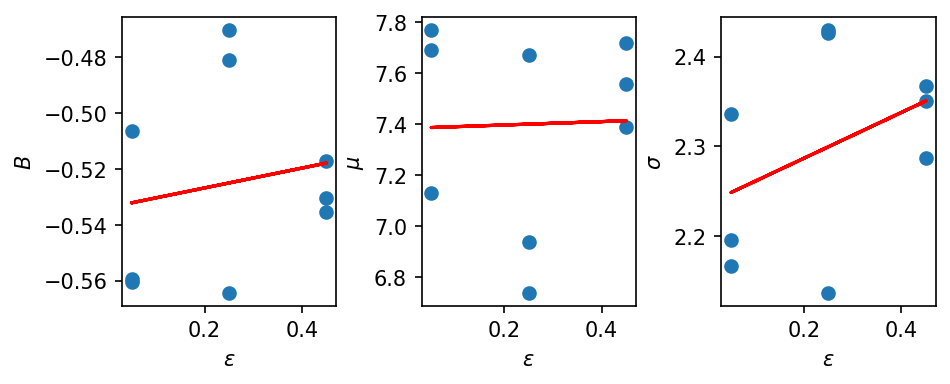

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:173: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


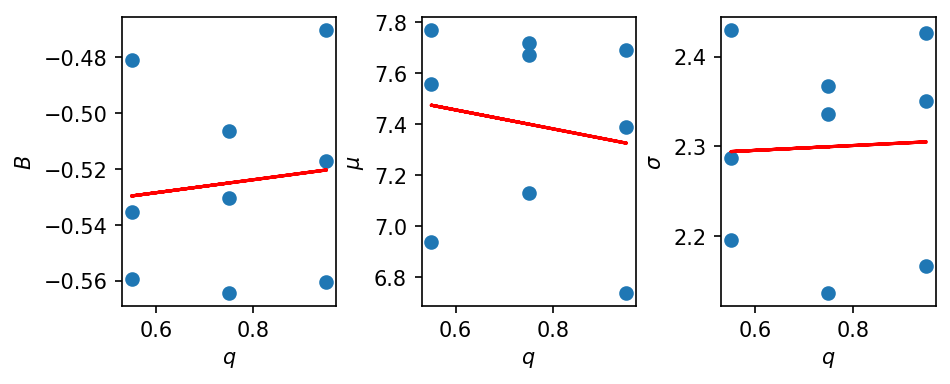

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:88: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


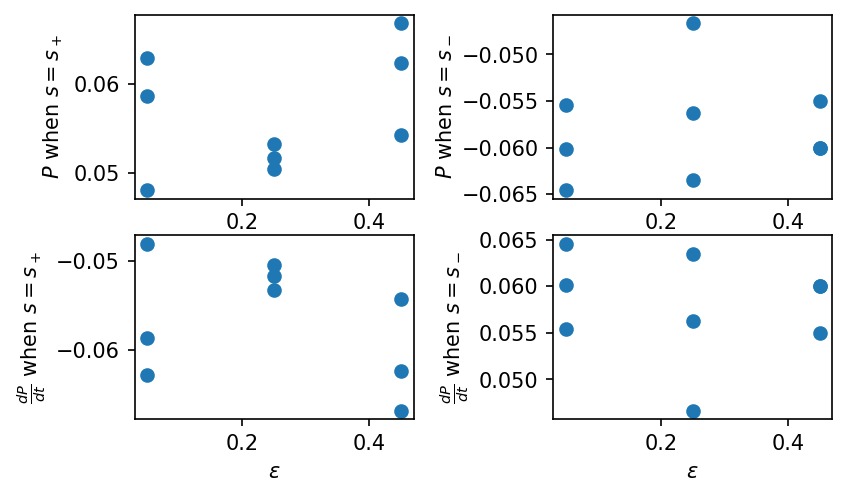

In [99]:
VSK = load(path+'VSK_data_0706.csv')
plot_eps(VSK)
plot_q(VSK)
get_threshold(VSK)

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:135: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


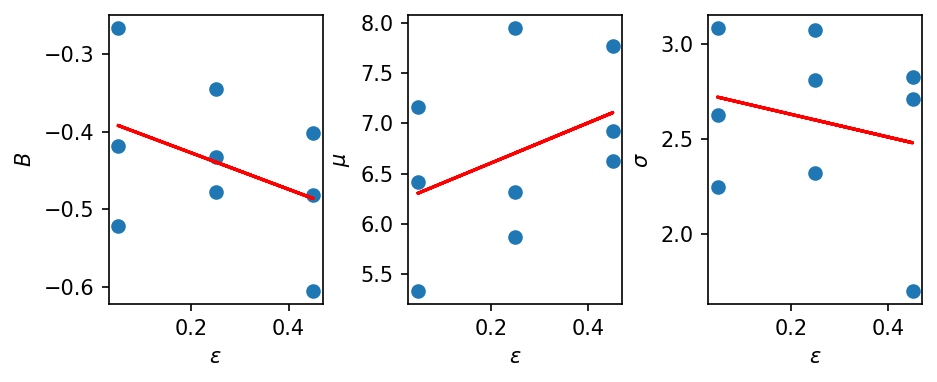

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:173: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


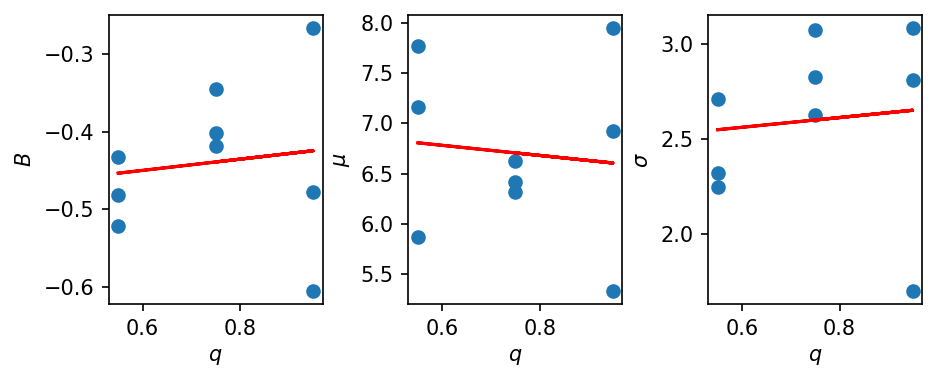

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:88: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


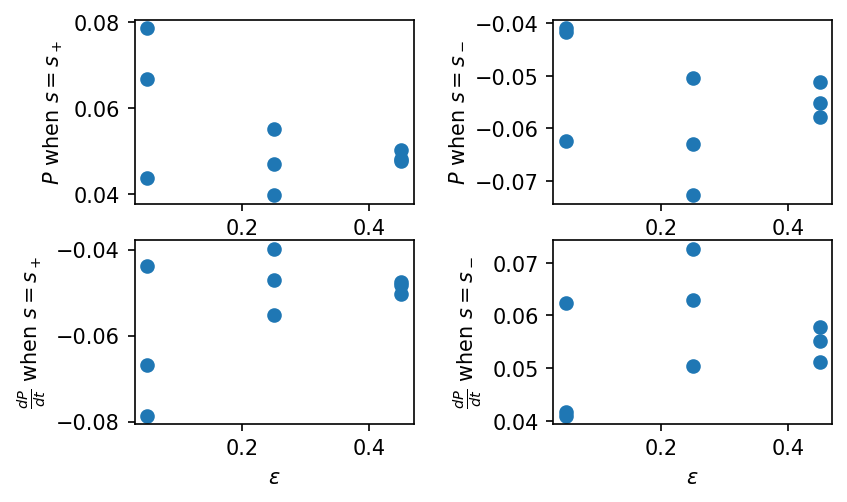

In [100]:
ZA = load(path+'ZA_data_0706.csv')
plot_eps(ZA)
plot_q(ZA)
get_threshold(ZA)

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:135: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


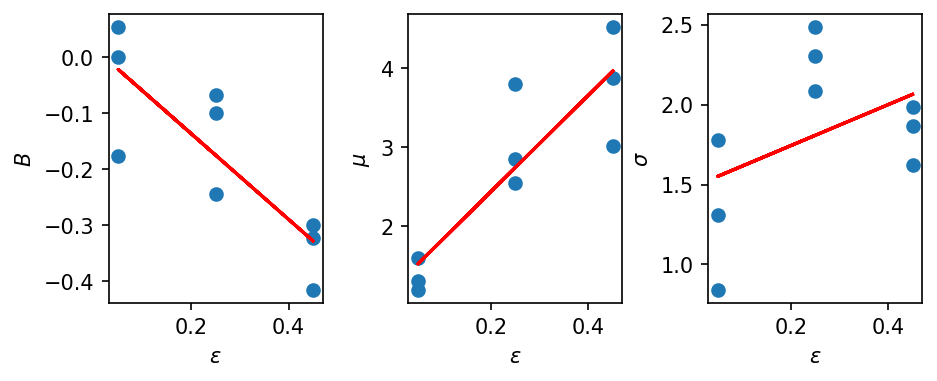

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:173: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


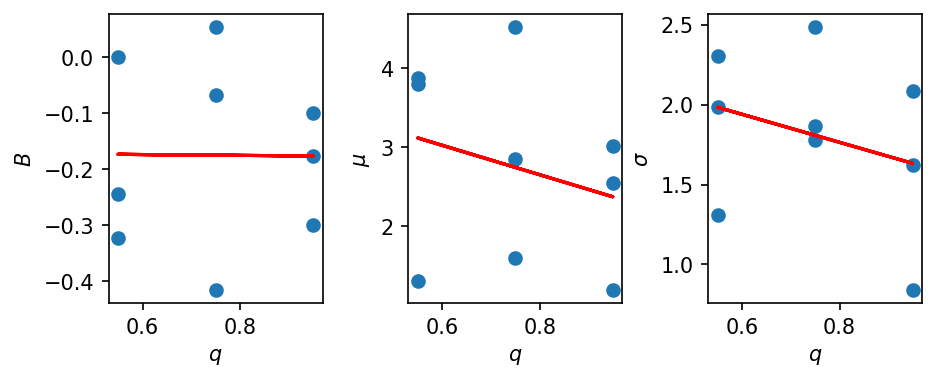

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:88: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


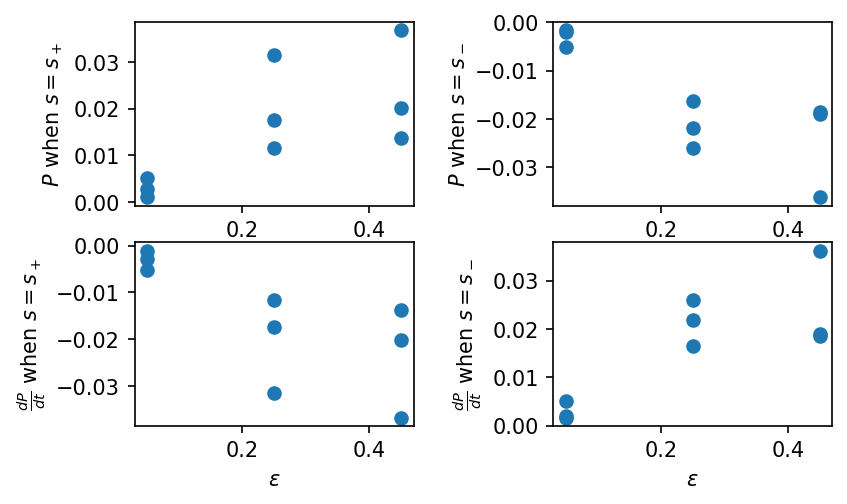

In [101]:
KM = load(path+'KM_data_0706.csv')
plot_eps(KM)
plot_q(KM)
get_threshold(KM)

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:135: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


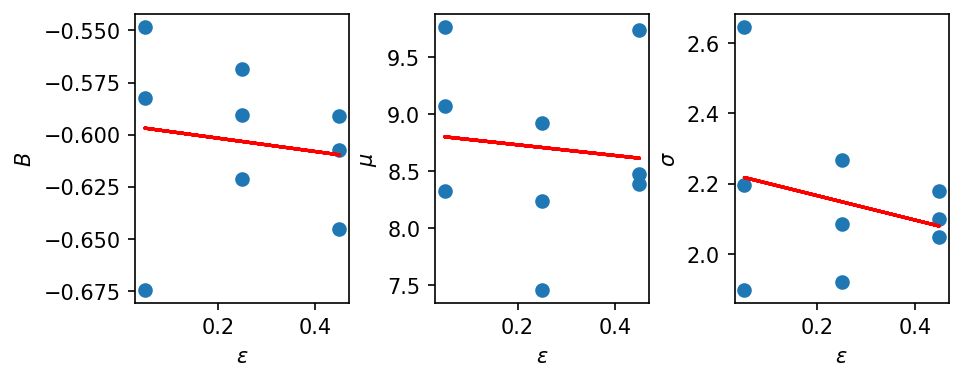

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:173: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


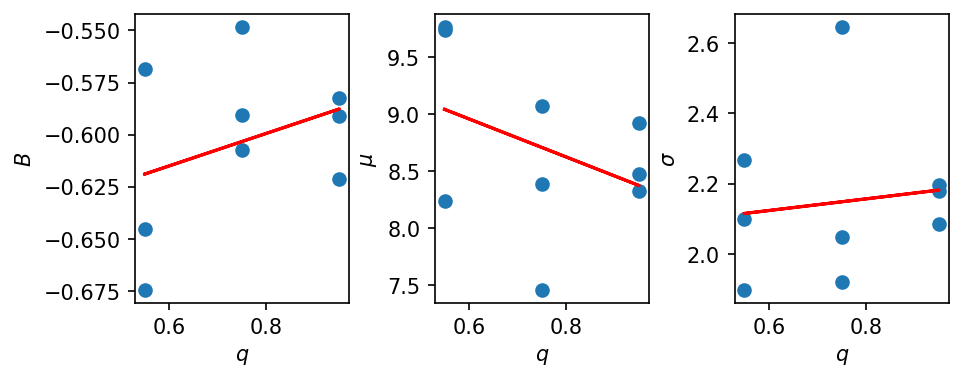

/var/folders/q8/zpq0tl7n1t77mdfn9rv0b25r0000gn/T/ipykernel_63848/1746723537.py:88: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


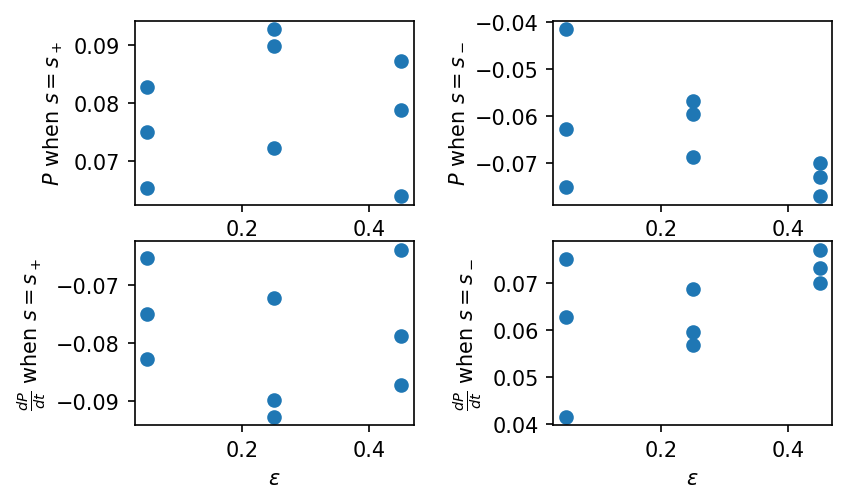

In [102]:
JB = load(path+'JB_data_0707.csv')
plot_eps(JB)
plot_q(JB)
get_threshold(JB)

# Discussion
We see no real consistent change as a function of $\epsilon$, which is either because the problem is ill-posed or because people are just not good at weighing information properly. It seems like they weight information about the uncertainty on the information-generating process much more than they weight information about the actual uncertainty of the state (which is what an ideal observer would catch on to). Is this because they don't know what 'volatility' means, or are we just inherently biased towards always sampling some evidence because we fear being misinformed? Or maybe we think that the uncertainty of the evidence-generating process (which is not that relevant if you know $\epsilon$) is more important the the actual state volatility -- sub-optimal human behavior?